In [47]:
# Load packages

import os
from typing import Optional
import numpy as np
import pandas as pd

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
from torch import nn
import torchvision.transforms as transforms
import json
from os import path
from typing import Self, TypedDict, Union, Optional, Literal, List, Tuple
import time
import cv2 as cv
import glob

import matplotlib.pyplot as plt

In [48]:
DATA_FOLDER_DICT = {'Victor':'E:\DeepFakeDetection\dfdc_train_all',
                'Nitzan':'D:\dfdc',
                'Netanel':''}
DATA_FOLDER = DATA_FOLDER_DICT['Victor']

NUM_PARTS = 50
Split = Union[Literal['train'], Literal['validation']]
Label = Union[Literal[0], Literal[1]]

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

The chosen device: cuda


In [49]:
part_folders = os.listdir(DATA_FOLDER)
meta_df = pd.DataFrame()

for ii in range(len(part_folders)):
    part_folder = part_folders[ii]
    part_subfolders = os.listdir(os.path.join(DATA_FOLDER, part_folder))
    part_subfolder = part_subfolders[0]
    part_subfolder_path = os.path.join(os.path.join(DATA_FOLDER, part_folder), part_subfolder)
    files = os.listdir(part_subfolder_path)
    json_file = [file for file in files if  file.endswith('json')][0]
    json_file_path = os.path.join(part_subfolder_path, json_file)
    part_df = pd.read_json(json_file_path).T
    part_df['part'] = ii
    part_df['path'] = part_subfolder_path
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])

display(meta_df)

,label,split,original,part,path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
vpmyeepbep.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fzvpbrzssi.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
...,...,...,...,...,...
pdooqxqfrm.mp4,FAKE,train,ikebomnsiq.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
djjdcnhlma.mp4,FAKE,train,kudvvlgiff.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fgmbxfqoze.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
cywebjaezn.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...


In [50]:
files_num = sum([len(files) for r, d, files in os.walk(DATA_FOLDER)])+1
print(f"Data samples: {files_num}")

Data samples: 119197


<Axes: title={'center': 'Histogram of Classes / Labels'}, xlabel='Class', ylabel='Count'>

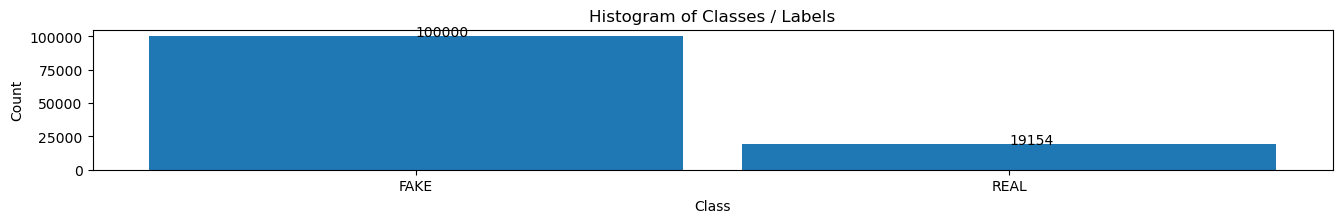

In [51]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

plt.figure(figsize=(16, 4))
ax = plt.subplot(2,1,1)
PlotLabelsHistogram(meta_df['label'],meta_df['label'].unique(),ax)

In [61]:

class FileMetadata(TypedDict):
  path: str
  label: Union[Literal['REAL'], Literal['FAKE']]
  original: Optional[str]

class VideoDataset(Dataset):
  def __init__(self: Self, root_path: str, split: Split):
    self.root_path = root_path
    print(root_path)

    # Init metadata
    self.metadata: List[FileMetadata] = []
    metadata_glob = glob.iglob('**/metadata.json', recursive=True, root_dir=root_path)
    metadata_paths = [path.join(root_path, p) for p in metadata_glob]
    for metadata_path in metadata_paths:
      # print(f'reading metadata from {metadata_path}...')
      # start = time.time()
      metadata = json.load(open(metadata_path))
      # post_load = time.time()
      # print(f'loading json took {1_000*(post_load - start):.2f}ms')
      for k, data in metadata.items():
        if data['split'] != split:
          continue

        video_path = path.join(path.dirname(metadata_path), k)
        data['path'] = video_path
        del data['split']

        self.metadata.append(data)
      
      # post_parse = time.time()
      # print(f'parsing json took {1_000*(post_parse - post_load):.2f}ms')


  def __getitem__(self: Self, index: int) -> Tuple[torch.Tensor, Label]:
    metadata = self.metadata[index]
    # How do we handle the audio as well?
    video, _, _ = read_video(metadata['path'], output_format="TCHW", pts_unit='sec', start_pts=0, end_pts=8)
    video = transforms.Compose([
      # transforms.CenterCrop(500),
      # transforms.Lambda(lambda x: torch.narrow(x, 0, 0, 240))
    ])(video)
    label = 1 if metadata['label'] == 'FAKE' else 0

    return video, label
  
  def __len__(self: Self):
    return len(self.metadata)

In [62]:
# Test the VideoDataset
loader = DataLoader(VideoDataset(DATA_FOLDER, 'train'), batch_size=1, shuffle=True)

E:\DeepFakeDetection\dfdc_train_all


torch.Size([1, 240, 3, 1280, 720])


TypeError: Invalid shape (240, 1280, 720, 3) for image data

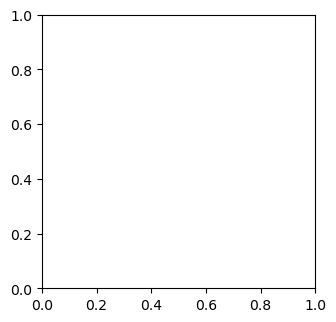

In [63]:
from matplotlib import pyplot as plt

# Get some images & labels from the data loader

data, label = next(iter(loader))

# data dimensions are BxTxCxHxW

B,T,C,H,W = data.shape
print(data.shape)
data = data.reshape(B,T,H,W,C)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 3, 1)
plt.imshow(data[0][0])
fig.add_subplot(1, 3, 2)
plt.imshow(data[0][100])
fig.add_subplot(1, 3, 3)
plt.imshow(data[0][-1])

print(label)
